<!-- File automatically generated using DocOnce (https://github.com/doconce/doconce/):
doconce format ipynb MLP.do.txt  -->

## Exploring Multi-Layer Perceptrons (MLP) and the XOR Problem
This notebook takes inspiration from the following sources:
1. <https://towardsdatascience.com/how-neural-networks-solve-the-xor-problem-59763136bdd7> (2023)
2. <https://www.quora.com/Why-cant-the-XOR-problem-be-solved-by-a-one-layer-perceptron> (2023)

In [1]:
%matplotlib inline

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (4, 2)
plt.rcParams['figure.dpi'] = 150

In their 1969 book, "Perceptrons: An Introduction to Computational Geometry" 
Marvin Minsky and Seymour A. Papert demonstrated that perceptrons could not solve the XOR problem. 
In this notebook, we will revisit this argument and become more familiar with perceptrons, gradient learning, 
and the limitations of such simple models. This discussion will also provide a compelling example of why 
we should consider multi-layer perceptrons instead of single-layer perceptrons. 
<!-- Finally, we will generalize our example to arbitrary functions using the universal approximation theorem. -->

## The Perceptron
A perceptron is a linear, [single-valued function](https://mathworld.wolfram.com/Single-ValuedFunction.html) 
$f: \mathbb{R}^N \rightarrow \mathbb{R}$, accompanied by a subsequent thresholding function:

$$
\begin{align*}
g(x) = 
\begin{cases}
& 1, \ x > T \\
& 0, \ \text{otherwise} \\
\end{cases}
\end{align*}
$$

where $T$ is a threshold value, typically set to 0. We can visualize the thresholding function as follows:

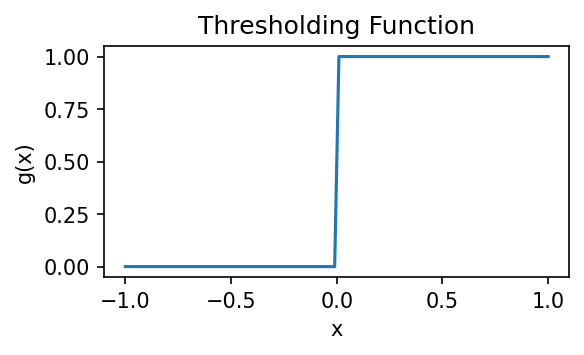

In [2]:
def g(x, T=0):
    """
    Thresholding function

    Parameters:
        x, float: Input to thresholding function
        T, float: Threshold value, typically (default) set to 0
    Returns:
        y, float: Output of thresholding function
    """
    return x > T

x = np.linspace(-1,1,100)
plt.plot(x, g(x))
plt.xlabel('x')
plt.ylabel('g(x)')
plt.title('Thresholding Function')
plt.show()

## XOR: The input and target
The XOR function maps two binary values to a third binary value, 
$f: \{0,1\}^2 \rightarrow \{0,1\}$, as depicted in the following Boolean logic table:

<table class="dotable" border="1">
<thead>
<tr><th align="center">A</th> <th align="center">B</th> <th align="center">XOR</th> </tr>
</thead>
<tbody>
<tr><td align="center">   0    </td> <td align="center">   0    </td> <td align="center">   0      </td> </tr>
<tr><td align="center">   0    </td> <td align="center">   1    </td> <td align="center">   1      </td> </tr>
<tr><td align="center">   1    </td> <td align="center">   0    </td> <td align="center">   1      </td> </tr>
<tr><td align="center">   1    </td> <td align="center">   1    </td> <td align="center">   0      </td> </tr>
</tbody>
</table>

We begin by defining the domain-codomain (input-outputs) of the XOR function. This provides the inputs and 
targets that our function should try to fit.

In [3]:
def xor():
    """
    Define the input and output of the XOR-function

    Returns:
        A_B, XOR: A 2d-tuple of the input-output pairs of the XOR-function
    """
    A_B = np.array([
        [0,0],
        [0,1],
        [1,0],
        [1,1]
    ])
    XOR = np.array([
        0,
        1,
        1,
        0
    ])
    return A_B, XOR

Let us plot the input-output pairs of the XOR function:

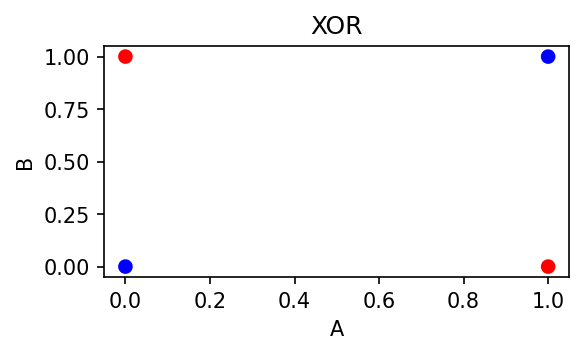

In [4]:
# get input-output pairs
A_B, XOR = xor()
# plot the input-output pairs
plt.scatter(A_B[:,0], A_B[:,1], c=XOR, cmap='bwr')
plt.xlabel('A')
plt.ylabel('B')
plt.title('XOR')
plt.show()

Before moving on, can you think of a way to draw a line that separates the input-output pairs of the XOR function?

## Exercise 1: Creating a 2D Perceptron

To build the perceptron we will use the Variable class that we created in the previous notebook. We import this class from the variable module.

Following, we provide you with a skeleton for a perceptron. Your task is to fill in the missing "___" parts in the 
`forward`, `evaluate` and `loss_fn` functions.

*Note that: We set the bias to -1 to arrive at a an interesting solution where the 
decision boundary lives near the XOR data points.*

In [10]:
from variable import Variable

class Perceptron2D:
    def __init__(self, T=0, lr=1e-1):
        """
        Two dimensional Percetron (we assume only two weights and thus two inputs) for 
        attempting to learn the XOR-function.

        Parameters:
            T, float: Threshold value, typically (default) set to 0
            lr, float: Learning rate for gradient descent
        """
        self.T, self.lr = T, lr
        # initialise weights and biases - here from a random uniform distribution with range [0,1] 
        self.w1 = Variable(np.random.uniform())
        self.w2 = Variable(np.random.uniform())
        self.bias = Variable(-1)
    
    def forward(self,A,B):
        """
        Evaluates the (linear part of the) perceptron for a given input

        Parameters:
            A,B, Variable: Current input to perceptron
        Returns:
            y_hat, Variable: A Variable object following the perceptron auto-diff graph
        """
        y_hat =  self.w1*A + self.w2*B + self.bias
        return y_hat

    def evaluate(self,A,B):
        """
        Extends the forward function to include thresholding (full Perceptron forward)

        Parameters:
            A,B, Variable: Current input to perceptron
        Returns:
            y_pred, bool: Boolean (True/False or equivalently 0/1), the (full) forward pass of the perceptron
        """
        y_hat = self.forward(A,B)
        # NOTE! ">" is not defined for Variable objects, so we need to extract the value
        return y_hat.value > self.T

    def loss_fn(self,A,B,y):
        """
        Computes the loss function for a given input

        Parameters:
            A,B, Variable: Current input to perceptron
            y, Variable: Target value for the input
        Returns:
            loss, Variable: A Variable object following the loss auto-diff graph
        """
        y_hat = self.forward(A,B)
        loss = (y_hat - y)**2
        return loss

    def gradient_step(self, A, B, y):
        """
        Performs a gradient step for a given input

        Parameters:
            A,B, Variable: Current input to perceptron
            y, Variable: Target value for the input
        """
        # forward pass
        loss = self.loss_fn(A,B,y)
        # backward pass
        grads = loss.gradients
        # update weights and omit bias
        w1 = self.w1 - self.lr*grads[self.w1]
        w2 = self.w2 - self.lr*grads[self.w2]
        # we need to reinstantiate the Variable object to avoid infinite recursion
        self.w1 = Variable(w1.value)
        self.w2 = Variable(w2.value)
        return loss.value # to track loss

<!-- --- begin solution of exercise --- -->
**Solution.**

In [11]:
from variable import Variable

class Perceptron2D:
    def __init__(self, T=0, lr=1e-1):
        """
        Two dimensional Percetron (we assume only two weights and thus two inputs) for 
        attempting to learn the XOR-function.

        Parameters:
            T, float: Threshold value, typically (default) set to 0
            lr, float: Learning rate for gradient descent
        """
        self.T, self.lr = T, lr
        # initialise weights and biases - here from a random uniform distribution with range [0,1] 
        self.w1 = Variable(np.random.uniform())
        self.w2 = Variable(np.random.uniform())
        self.bias = Variable(-1)
    
    def forward(self,A,B):
        """
        Evaluates the (linear part of the) perceptron for a given input

        Parameters:
            A,B, Variable: Current input to perceptron
        Returns:
            y_hat, Variable: A Variable object following the perceptron auto-diff graph
        """
        y_hat = A*self.w1 + B*self.w2 + self.bias
        return y_hat

    def evaluate(self,A,B):
        """
        Extends the forward function to include the thresholding (full Perceptron forward)

        Parameters:
            A,B, Variable: Current input to perceptron
        Returns:
            y_pred, bool: Boolean (True/False or equivalently 0/1), the (full) forward pass of the perceptron
        """
        y_hat = self.forward(A,B)
        # NOTE! ">" is not defined for Variable objects, so we need to extract the value
        return y_hat.value > self.T

    def loss_fn(self,A,B,y):
        """
        Computes the loss function for a given input

        Parameters:
            A,B, Variable: Current input to perceptron
            y, Variable: Target value for the input
        Returns:
            loss, Variable: A Variable object following the loss auto-diff graph
        """
        y_hat = self.forward(A,B)
        loss = (y_hat - y)**2
        return loss

    def gradient_step(self, A, B, y):
        """
        Performs a gradient step for a given input

        Parameters:
            A,B, Variable: Current input to perceptron
            y, Variable: Target value for the input
        """
        # forward pass
        loss = self.loss_fn(A,B,y)
        # backward pass
        grads = loss.gradients
        # update weights and omit bias
        w1 = self.w1 - self.lr*grads[self.w1]
        w2 = self.w2 - self.lr*grads[self.w2]
        # we need to reinstantiate the Variable object to avoid infinite recursion
        self.w1 = Variable(w1.value)
        self.w2 = Variable(w2.value)
        return loss.value # to track loss

<!-- --- end solution of exercise --- -->

## Exercise 2: Training

We now train the perceptron for a given number of epochs. We do this by looping over the input-output pairs.
For each pair, we compute the loss and perform a gradient step. We then track the loss over the epochs.

Fill in the missing code below to finish the train method for the perceptron.

In [12]:
import tqdm

def train(model, A_B, XOR, epochs=1000):
    """
    Trains the model for a given number of epochs

    Parameters:
        model, Perceptron2D: The model to train
        A_B, np.array: The input to the model
        XOR, np.array: The target output of the model
        epochs, int: The number of epochs to train for
    """
    loss_history = []
    for epoch in tqdm.trange(epochs):
        loss = 0
        for i in range(len(A_B)):
            A, B = A_B[i]
            y = XOR[i]
            # do a gradient step and track the loss
            loss += model.gradient_step(Variable(A),Variable(B),Variable(y))
        loss_history.append(loss)
    return loss_history

<!-- --- begin solution of exercise --- -->
**Solution.**

In [ ]:
import tqdm

def train(model, A_B, XOR, epochs=1000):
    """
    Trains the model for a given number of epochs

    Parameters:
        model, Perceptron2D: The model to train
        A_B, np.array: The input to the model
        XOR, np.array: The target output of the model
        epochs, int: The number of epochs to train for
    """
    loss_history = []
    for epoch in tqdm.trange(epochs):
        loss = 0
        for i in range(len(A_B)):
            A, B = A_B[i]
            y = XOR[i]
            # do a gradient step and track the loss
            loss += model.gradient_step(Variable(A), Variable(B), Variable(y))
        loss_history.append(loss)
    return loss_history

<!-- --- end solution of exercise --- -->

100%|██████████| 1000/1000 [00:00<00:00, 4208.12it/s]


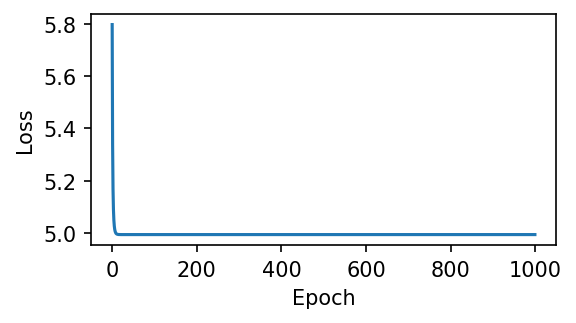

In [13]:
model = Perceptron2D()
A_B, XOR = xor()
loss_history = train(model, A_B, XOR, epochs=1000)
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## Insights into the Perceptron with decision boundaries
Now that we have trained the perceptron, we can plot the decision boundary of the perceptron. This is done by
evaluating the perceptron on a 2D mesh of the inputs. The decision boundary will be the contour where the perceptron
makes the decision to output 0 or 1.

In [14]:
def plot_decision_boundary(model, A_B, XOR, fig=None, ax=None):
    """
    Plots the decision boundary of the model

    Parameters:
        model, Perceptron2D: The model to plot the decision boundary of
        A_B, np.array: The input to the model
        XOR, np.array: The target output of the model
    """
    # plot the decision boundary
    x = np.linspace(-0.2,1.2,100)
    y = np.linspace(-0.2,1.2,100)
    X, Y = np.meshgrid(x,y)
    Z = np.zeros_like(X)
    for i in range(len(X)):
        for j in range(len(X[0])):
            Z[i,j] = model.evaluate(Variable(X[i,j]), Variable(Y[i,j]))
    if fig is None or ax is None:
        fig, ax = plt.subplots()
    ax.contourf(X,Y,Z, alpha=0.2)
    ax.scatter(A_B[:,0], A_B[:,1], c=XOR, cmap="coolwarm")
    ax.set_xlabel("A")
    ax.set_ylabel("B")
    return fig, ax

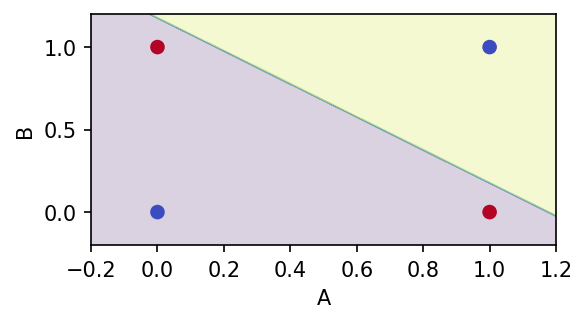

In [15]:
fig, ax = plot_decision_boundary(model, A_B, XOR)
plt.show()

## Exercise 3: Multi-Layer Perceptron: Understanding Layers and Non-Linearity

Our primary focus in this section is to understand two essential questions regarding Multi-Layer Perceptrons (MLP): 
"Why do we need multiple layers?" and "Why is non-linearity necessary?".

As we have shown, the shortcomings of a single-layer perceptron are evident when dealing with the infamous XOR problem. 
However, as we will see in this section, we can overcome this limitation by transitioning from a single-layer perceptron to a multi-layer perceptron.

Going from a single-layer perceptron to a multi-layer perceptron requires us to address two crucial factors:

1. Merely adding another linear layer without introducing non-linearity does NOT increase the expressive power of our model.
2. The non-linearity that we introduce must be differentiable and possess a broad [support](https://en.wikipedia.org/wiki/Support_(mathematics)). 

The second point allows us to use gradient-based optimization techniques, such as variants of gradient descent. 
Moreover, if the function's gradient is zero in "large enough" regions, learning will stop. 
This consideration highlights that we can't merely expand our previous perceptron using thresholding functions, 
as its derivative is zero everywhere.

**a)**
Demonstrate that simply adding another linear layer without incorporating non-linearity does not enhance the expressiveness of the model. 
To clarify, given a neural network, which can be represented as a composition of functions $f(x) = f_1 \circ f_2 \circ ... \circ f_n (x)$, 
where each function is linear, i.e., $f_i(z) = W_i z + b_i$, you are required to show that $f(x)$ can be reduced to a single linear transform $W'x + b'$. 

Hint: Begin by writing the function $f(x)$ explicitly in terms of its weights, biases, and input. 
Subsequently, simplify and argue that a transformation of this form is equivalent to $W'x + b'$.

<!-- --- begin solution of exercise --- -->
**Solution.**


We can find the solution by following the hint. Expanding the function, we get

$$
\begin{align*}
f(x) &= W_n(W_{n-1}(...(W_1 x + b_1)) + b_{n-1}) + b_n \\
     &= W_n W_{n-1} ... W_1 x + b_n + W_n b_{n-1} + W_n W_{n-1} b_{n-2} + ... + W_n W_{n-1} ... W_2 b_1 + ... + W_1
\end{align*}
$$

Here, we can simply choose $W' = W_n W_{n-1} ... W_1$, and $b' = b_n + W_n b_{n-1} + W_n W_{n-1} b_{n-2} + ... + W_n W_{n-1} ... W_2 b_1 + ... + W_1$.
<!-- --- end solution of exercise --- -->

**b)**
(`OPTIONAL`) In this exercise we want to extend the above argument to neural networks with polynomial activation functions. 
To get you started, we will first consider a single-layer perceptron with a polynomial activation function of degree 2.
1. Consider a two-layer neural network where each layer is a polynomial function of degree 2, in the form $f_i(z) = W_i z^2$ (omitting the bias). 
    a. Show that this two-layer network can be simplified to a single-layer network with a polynomial function of degree 4. 
    b. Based on this, argue why the expressiveness of the multi-layer network does not exceed that of the single-layer network.
2. In general, argue that a multi-layer perceptron with polynomial activation functions does not have an increased expressiveness over a single-layer perceptron with a polynomial activation function of any degree.
`Hint`: Recall that expressiveness refers to the set of functions that a network can represent. 
A model is said to be more expressive if it can represent a strictly larger set of functions.

**Solution.**

`Part 1`:
Ignoring the bias terms, our two layer neural network function would look like this:

$f(x) = f_2(f_1(x)) = W_2(W_1 x^2)^2$

Expanding the inner function, we get:

$f(x) = W_2(W_1^2 x^4)$

So the output of the two-layer network is a scaled fourth degree polynomial.
Now, let's compare this to a single-layer network with a fourth degree polynomial activation function:

$f(x) = W_4 x^4$

If we set $W_4 = W_2W_1^2$, then the single-layer network can represent the same function as the two-layer network. 
Hence, we have shown that a single-layer network with a fourth degree polynomial activation function can represent the 
same function as a two-layer network with second degree polynomial functions.

`Part 2`:
In the context of neural networks, the term "expressiveness" refers to the family of functions that a network can approximate. 
A network is considered more expressive if it can approximate a broader range of functions.

In the case of a multi-layer perceptron with polynomial activation functions, it might seem that stacking layers to generate higher degree 
polynomials would increase the network's expressiveness. However, this is not the case when comparing it to a single-layer network with a 
sufficiently flexible polynomial activation function.

Let's illustrate this using mathematical notation. Let $P_n$ denote the set of all real polynomial functions of degree up to $n$. 
If we have a single-layer network with an activation function from $P_m$, we can write its function as:

$f(x) = W_m x^m + W_{m-1} x^{m-1} + ... + W_1 x + b \quad f \in P_m$

This function belongs to $P_m$, meaning it can represent any real polynomial function of degree up to $m$.

Now, suppose we have a multi-layer perceptron, where each layer is a polynomial function from $P_n$. 
When stacked together, these layers form a composite function that is in $P_{n^k}$, where $k$ is the number of layers. 
However, if $m \geq n^k$, then the single-layer network with activation function from $P_m$ can represent the same set of functions as 
the multi-layer network.

Therefore, adding more layers to a multi-layer perceptron doesn't inherently increase the expressiveness beyond what a single-layer network 
with a polynomial activation function from $P_m$

## The sigmoid function
As a result, we must identify a different non-linear function to replace our thresholding function. 
Traditionally, the sigmoid function, defined as

$$
\begin{align*}
\sigma(x) = \frac{1}{1+\exp{-x}}, 
\end{align*}
$$

is selected for this purpose. 
This function bears a similarity to the thresholding function and can be thought of as a smoother (differentiable) version of it.

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.linspace(-5,5,100)
plt.plot(x, sigmoid(x))
plt.xlabel("x")
plt.ylabel("$\sigma(x)$")
plt.show()

## The XOR problem reformulated
While it is normally not clear how many layers and neurons are needed to approximate a given function, 
for the XOR problem we can show that a two-layer perceptron with two neurons in each layer is sufficient.
While this is interesting, we omit the details of (which can be found in the resource section), and instead
just state the result: XOR can be written as,

$$
\begin{align*}
XOR(A,B) = (A + B) \cdot \bar{AB}
\end{align*}
$$

where $+$ represents the logical OR operation, and $\bar{AB}$ denotes the logical NAND operation. 
It is important to note that both NAND and OR are linearly separable functions, 
which means they can be approximated by individual single-layer 2D-perceptrons. 
Furthermore, since the output of each function is a single bit, 
they can be combined using the logical AND operation, which is also linearly separable. 
By combining these components, we can create a two-layer perceptron capable of approximating the XOR function.

Confirm by yourself that you can linearly separate the XOR function using the logical OR, NAND, and AND operations
by looking at the following plots:

In [ ]:
A, B = A_B.T
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[0].scatter(A, B, c=A|B, cmap='bwr')
ax[0].set_title("OR")
ax[1].scatter(A, B, c=~(A&B), cmap='bwr')
ax[1].set_title("NAND")
ax[2].scatter(A, B, c=A&B, cmap='bwr')
ax[2].set_title("AND")
plt.show()

## Exercise 4: Implementing a two-layer perceptron

Let us now implement a two-layer perceptron in Python, again using the Variable class from the previous section.

Fill in the missing code in the `forward` function to finish the implementation of a two-layer perceptron.

In [ ]:
class MLP:
    def __init__(self, T=0.5, lr=1e-1):
        """
        A two layer perceptron with two neurons in each layer
        """
        self.T, self.lr = T, lr
        # initialize weights and bias for first layer
        # hidden neuron one
        self.w11 = Variable(np.random.normal(scale=0.1))
        self.w12 = Variable(np.random.normal(scale=0.1))
        self.b11 = Variable(np.random.normal(scale=0.01))
        # hidden neuron two
        self.w13 = Variable(np.random.normal(scale=0.1))
        self.w14 = Variable(np.random.normal(scale=0.1))
        self.b12 = Variable(np.random.normal(scale=0.01))
        # initialize weights and bias for second layer
        # output neuron
        self.w21 = Variable(np.random.normal(scale=0.1))
        self.w22 = Variable(np.random.normal(scale=0.1))
        self.b21 = Variable(np.random.normal(scale=0.01))

    def sigmoid(self, x):
        """
        Recreate the sigmoid function using the Variable class
        """
        from variable import exp
        return 1 / (1 + exp(-x))
    
    def forward(self,A,B):
        """
        Forward of the MLP for a given input

        Parameters:
            A,B, Variable: Current input to the MLP
        Returns:
            y_hat, Variable: A Variable object following the perceptron auto-diff graph
        """
        #
        # ----> FILL IN MISSING CODE HERE <----
        #
        return NotImplementedError

    def evaluate(self,A,B):
        """
        Evaluates the MLP for a given input - thresholds the forward pass

        Parameters:
            A,B, Variable: Current input to perceptron
        Returns:
            y_hat, Variable: A Variable object following the perceptron auto-diff graph
        """
        y_hat = self.forward(A,B)
        return y_hat.value > self.T

    def loss_fn(self,A,B,y):
        """
        Computes the loss function for a given input

        Parameters:
            A,B, Variable: Current input to MLP
            y, Variable: Target value for the input
        Returns:
            loss, Variable: A Variable object following the loss auto-diff graph
        """
        y_hat = self.forward(A,B)
        loss = (y_hat - y)**2
        return loss

    def gradient_step(self, A, B, y):
        """
        Performs a gradient step for a given input

        Parameters:
            A,B, Variable: Current input to MLP
            y, Variable: Target value for the input
        """
        # forward pass
        loss = self.loss_fn(A,B,y)
        # backward pass
        grads = loss.gradients
        # update weights and bias
        self.w11 = Variable((self.w11 - self.lr*grads[self.w11]).value)
        self.w12 = Variable((self.w12 - self.lr*grads[self.w12]).value)
        self.w13 = Variable((self.w13 - self.lr*grads[self.w13]).value)
        self.w14 = Variable((self.w14 - self.lr*grads[self.w14]).value)
        self.b11 = Variable((self.b11 - self.lr*grads[self.b11]).value)
        self.b12 = Variable((self.b12 - self.lr*grads[self.b12]).value)
        self.w21 = Variable((self.w21 - self.lr*grads[self.w21]).value)
        self.w22 = Variable((self.w22 - self.lr*grads[self.w22]).value)
        self.b21 = Variable((self.b21 - self.lr*grads[self.b21]).value)
        return loss.value # to track loss

<!-- --- begin solution of exercise --- -->
**Solution.**

In [ ]:
class MLP:
    def __init__(self, T=0.5, lr=1e-1):
        """
        A two layer perceptron with two neurons in each layer
        """
        self.T, self.lr = T, lr
        # initialize weights and bias for first layer
        # hidden neuron one
        self.w11 = Variable(np.random.normal(scale=0.1))
        self.w12 = Variable(np.random.normal(scale=0.1))
        self.b11 = Variable(np.random.normal(scale=0.01))
        # hidden neuron two
        self.w13 = Variable(np.random.normal(scale=0.1))
        self.w14 = Variable(np.random.normal(scale=0.1))
        self.b12 = Variable(np.random.normal(scale=0.01))
        # initialize weights and bias for second layer
        # output neuron
        self.w21 = Variable(np.random.normal(scale=0.1))
        self.w22 = Variable(np.random.normal(scale=0.1))
        self.b21 = Variable(np.random.normal(scale=0.01))

    def sigmoid(self, x):
        """
        Recreate the sigmoid function using the Variable class
        """
        from variable import exp
        return 1 / (1 + exp(-x))
    
    def forward(self,A,B):
        """
        Forward of the MLP for a given input

        Parameters:
            A,B, Variable: Current input to the MLP
        Returns:
            y_hat, Variable: A Variable object following the perceptron auto-diff graph
        """
        # first layer
        z1 = A*self.w11 + B*self.w12 + self.b11 # "first perceptron"
        z2 = A*self.w13 + B*self.w14 + self.b12 # "second perceptron"
        y1 = self.sigmoid(z1)
        y2 = self.sigmoid(z2)
        # second layer
        y_hat = y1*self.w21 + y2*self.w22 + self.b21 # "third perceptron"
        return self.sigmoid(y_hat)

    def evaluate(self,A,B):
        """
        Evaluates the MLP for a given input - thresholds the forward pass

        Parameters:
            A,B, Variable: Current input to perceptron
        Returns:
            y_hat, Variable: A Variable object following the perceptron auto-diff graph
        """
        y_hat = self.forward(A,B)
        return y_hat.value > self.T

    def loss_fn(self,A,B,y):
        """
        Computes the loss function for a given input

        Parameters:
            A,B, Variable: Current input to MLP
            y, Variable: Target value for the input
        Returns:
            loss, Variable: A Variable object following the loss auto-diff graph
        """
        y_hat = self.forward(A,B)
        loss = (y_hat - y)**2
        return loss

    def gradient_step(self, A, B, y):
        """
        Performs a gradient step for a given input

        Parameters:
            A,B, Variable: Current input to MLP
            y, Variable: Target value for the input
        """
        # forward pass
        loss = self.loss_fn(A,B,y)
        # backward pass
        grads = loss.gradients
        # update weights and bias
        self.w11 = Variable((self.w11 - self.lr*grads[self.w11]).value)
        self.w12 = Variable((self.w12 - self.lr*grads[self.w12]).value)
        self.w13 = Variable((self.w13 - self.lr*grads[self.w13]).value)
        self.w14 = Variable((self.w14 - self.lr*grads[self.w14]).value)
        self.b11 = Variable((self.b11 - self.lr*grads[self.b11]).value)
        self.b12 = Variable((self.b12 - self.lr*grads[self.b12]).value)
        self.w21 = Variable((self.w21 - self.lr*grads[self.w21]).value)
        self.w22 = Variable((self.w22 - self.lr*grads[self.w22]).value)
        self.b21 = Variable((self.b21 - self.lr*grads[self.b21]).value)
        return loss.value # to track loss

<!-- --- end solution of exercise --- -->

## Decision Boundary
Let us now visualize the decision boundary of the MLP to see how it performs on the XOR problem.

In [ ]:
fig, axs = plt.subplots(ncols=2)

# train model
model = MLP(lr=1e-1)
loss_history = train(model, A_B, XOR, epochs=10000)

# plot loss and decision boundary
axs[0].plot(loss_history)
plot_decision_boundary(model, A_B, XOR, fig=fig, ax=axs[1])
plt.show()